#### Импортируем данные

In [1]:
import pandas as pd
import numpy as np

import sklearn as skl

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Сохроняем версии библиотек

In [3]:
import sklearn
print(sklearn.__version__)
# 0.23.2

0.23.2


In [4]:
!pip freeze >> requirements.txt
# !conda list

полезная функция для оценки модели

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Считываем данные из файлов

In [6]:
train_df = pd.read_csv('train.csv') # test_df.head()
test_df = pd.read_csv('test.csv') # train_df.head()

### Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, , Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [7]:
print('Строк в трейне:', train_df.shape[0])  
print('Строк в тесте: ', test_df.shape[0])
train_df.shape[1] - 1 == test_df.shape[1] # проверим совподает ли количество признаков в датасетах

Строк в трейне: 10000
Строк в тесте:  5000


True

### Анализ целевой переменной 

расчитываем среднее, медиану и моду для цены

In [8]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

In [9]:
target_bins = train_df['Price'] // 10000 * 10000
target_adjusted_mode = target_bins.mode()[0]
target_adjusted_mode

180000.0

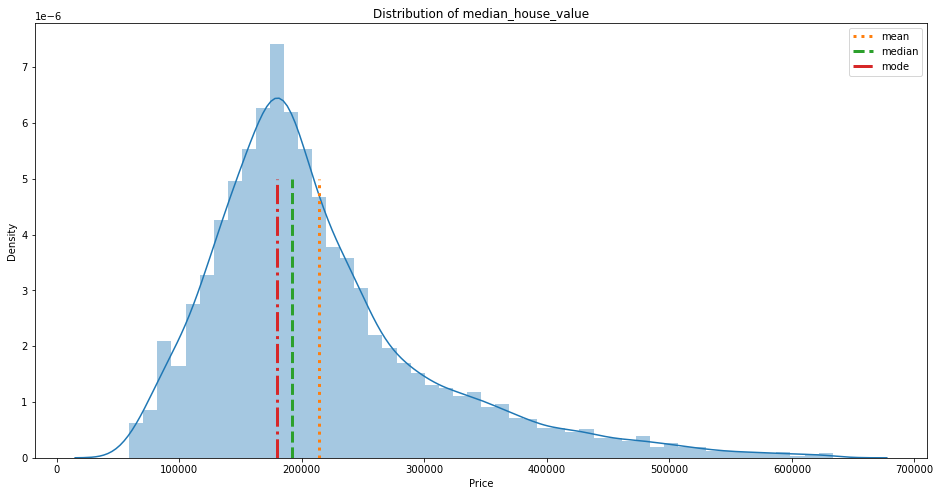

In [10]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50) 

y = np.linspace(0, 0.000005, 20)
plt.plot([target_mean] * 20, y, label='mean', linestyle=':', linewidth = 3)
plt.plot([target_median] * 20, y, label='median', linestyle='--', linewidth = 3)
plt.plot([target_adjusted_mode] * 20, y, label='mode', linestyle='-.', linewidth = 3)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

Мы видим, что все 3 характеристики вместе и рядом. Это - хорошо. Среднее стремится в сторону длинного хвоста, что закономерно.

### Анализируем признаки

In [11]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [12]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])

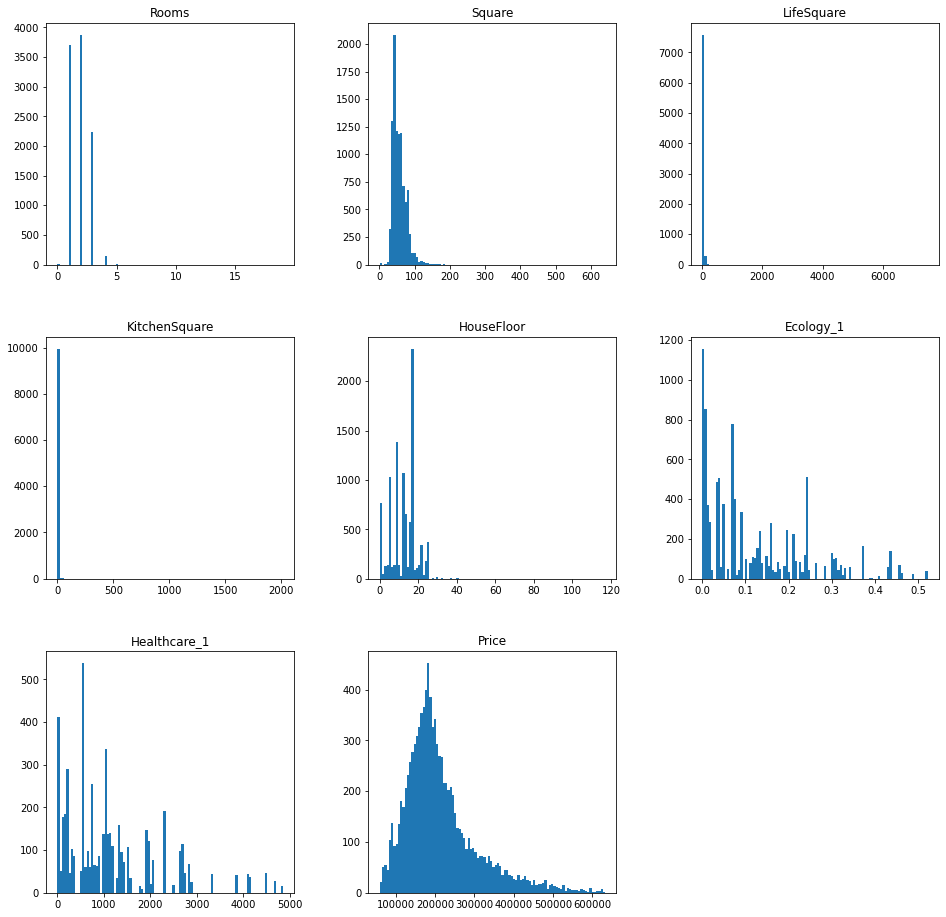

In [13]:
df_num_features.hist(figsize=(16, 16), bins=100, grid=False);

In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
print(train_df['Ecology_2'].value_counts())
print(train_df['Ecology_3'].value_counts())
print(train_df['Shops_2'].value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


Видим что разбиение по призннакам очень сильно отличается 

<Figure size 1152x576 with 0 Axes>

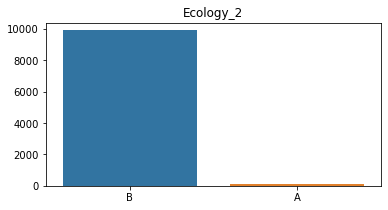

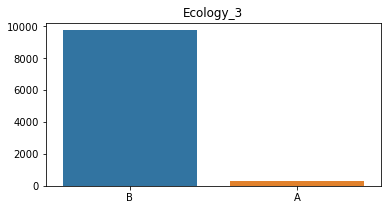

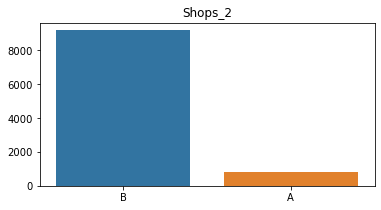

In [16]:
plt.figure(figsize = (16, 8))

counts = train_df['Ecology_2'].value_counts()   
plt.figure(figsize=(6, 3))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)

counts = train_df['Ecology_3'].value_counts()   
plt.figure(figsize=(6, 3))    
plt.title('Ecology_3')
sns.barplot(counts.index, counts.values)

counts = train_df['Shops_2'].value_counts()   
plt.figure(figsize=(6, 3))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)

plt.show()

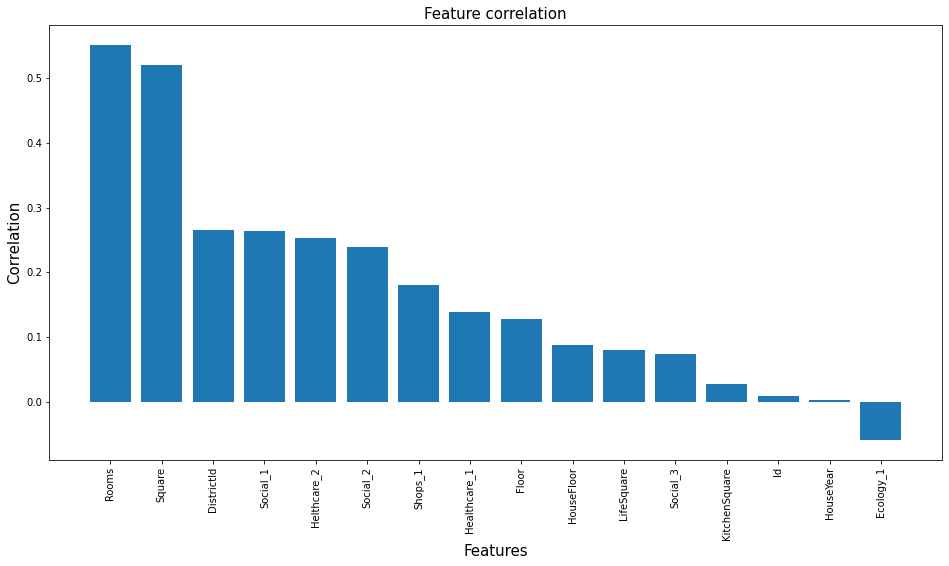

In [17]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [18]:
class DataPreprocessor:
    """Подготовка исходных данных"""
    def __init__(self):
        """Параметры класса"""
        self.medians = None # расчет медиан 
        self.kitchen_square_max_value = None # мин значение кухни  
        self.kitchen_square_min_value = None # макс значение кухни  
        self.life_square_min_value = None # мин значение площади 
        self.max_floor = None # макс этаж
        self.districts_healthcare = None


        
    def fit(self, df):
        """Сохранение статистик"""
        self.medians = df.median() 
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999)  # Убираем уж совсем выбросные значения 
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001)  # делаем это с помощью квантилей
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        self.max_floor = df['Floor'].max()
        
        
        # Вычисляем среднее значение Helthcare_1 в каждом районе
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        """Трансформация данных"""
        # Life Square fillna
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        # Fillna with medians         
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Вычисляем среднюю площадь комнаты и заполняем выбросы с помощью LifeSquare / Room_square 
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # Если LifeSquare > Square: меняем значение 
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))


        # LifeSquare
        # Заполняем выбросы (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]
  
        
        # KitchenSquare
        # Заполняем выбросы (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square'] - df.loc[condition_kitchen_square, 'LifeSquare'] \
        - (df.loc[condition_kitchen_square, 'Square'] * 0.1)


        # Ecology and Shops
        # Меняем на бинарные признаки
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # HouseFloor
        # Если HouseFloor < Floor: меняем значение
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']

        
        # HouseYear
        # Если HouseYear > current year запоняем медианой 
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        
        # Healthcare
        # Если в округе нет Healthcare, указываем медиану)      
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        
        # Drop Id
        df.drop(['Id'], axis=1, inplace=True)

        
        # Fillna на всякий случай 
        df.fillna(self.medians, inplace=True)
        return df


In [19]:
class FeatureGenerator:
    """Генерация новых фич"""
    
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # средний год дома в каждом районе
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  #средняя площадь в каждом районе
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # средняя стоимость квадрата в районе 
        
    
    def new_features(self, df):
        # Возраст района       
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Средняя площадь квартиры в каждом районе
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Средняя цена квадратного метра в каждом районе
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Этажи по категориям 
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Масштабирование и объединение Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        
        
        return df

In [20]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [21]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)

In [22]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Price,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
count,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000
mean,50.295859,1.888201,55.991763,37.935604,5.799360,13.480808,1984.881818,0.118887,24.720202,5361.290909,8.022828,942.494289,4.235657,214175.303440,1978.274495,53.400592,3813.938295,1.456465,-0.003253
std,43.603310,0.808149,17.683056,16.696288,4.453725,6.060537,18.397332,0.119110,17.531352,4007.944119,23.778269,725.293049,4.803159,92376.096661,9.277024,6.183996,993.864597,1.103962,4.755960
min,0.000000,1.000000,27.442238,-10.112607,-10.203789,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,1924.500000,33.533077,2093.831883,0.000000,-1.620569
25%,19.000000,1.000000,41.923325,25.129938,1.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,240.000000,1.000000,154250.429901,1975.000000,47.936648,2955.306014,0.000000,-1.606565
50%,35.000000,2.000000,52.633651,34.458807,6.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,3.000000,192359.511502,1977.000000,54.345128,3970.074724,1.000000,-1.210134
75%,75.000000,2.000000,65.894295,47.319963,9.000000,17.000000,2001.000000,0.195781,36.000000,7287.000000,5.000000,1322.000000,6.000000,249135.462171,1980.000000,56.876553,4422.596562,2.000000,-0.612411
max,209.000000,6.000000,134.231518,125.306808,72.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,2300.000000,23.000000,633233.466570,2011.000000,85.591121,8361.390680,3.000000,26.592147


In [23]:
test_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,51.279200,1.908963,56.591223,38.248927,5.815176,13.395000,1984.392600,0.119874,24.933800,5406.900000,8.262600,952.319776,4.242800,1978.295100,53.324971,3824.756155,1.456200,-1.450839e-16
std,44.179466,0.813480,19.407324,17.381090,4.444125,6.231945,18.573149,0.120070,17.532202,4026.614773,23.863762,735.925771,4.777365,9.247901,6.122255,979.194465,1.103778,4.772993e+00
min,0.000000,1.000000,1.378543,-11.139165,-11.090962,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,1924.500000,33.533077,2093.831883,0.000000,-1.663613e+00
25%,21.000000,1.000000,41.989020,25.172678,1.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,240.000000,1.000000,1975.000000,47.651571,2994.023919,0.000000,-1.651591e+00
50%,37.000000,2.000000,52.933734,34.629194,6.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,3.000000,1977.000000,54.345128,3975.516530,1.000000,-1.252385e+00
75%,77.000000,2.000000,66.416189,47.661475,9.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1322.000000,6.000000,1980.000000,56.876553,4422.596562,2.000000,-6.492014e-01
max,212.000000,7.105776,303.071094,168.729035,65.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,2300.000000,23.000000,2011.000000,83.883498,8361.390680,3.000000,2.654755e+01


Видим, что данные на трейне и тесте стали более адекватные уже нет выбросов, минимальные и максимальные значения, в основном,
адекватные

### Разбиение на train и test

In [24]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.15, random_state = 42)

### Постороение модели

In [25]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.864323938240456
0.7637631640800889


In [26]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
2,Square,0.266580
15,DistrictPrice,0.159067
1,Rooms,0.133737
9,Social_2,0.079757
3,LifeSquare,0.074758
4,KitchenSquare,0.042810
8,Social_1,0.042673
17,Social,0.038235
6,HouseYear,0.027174
0,DistrictId,0.022431


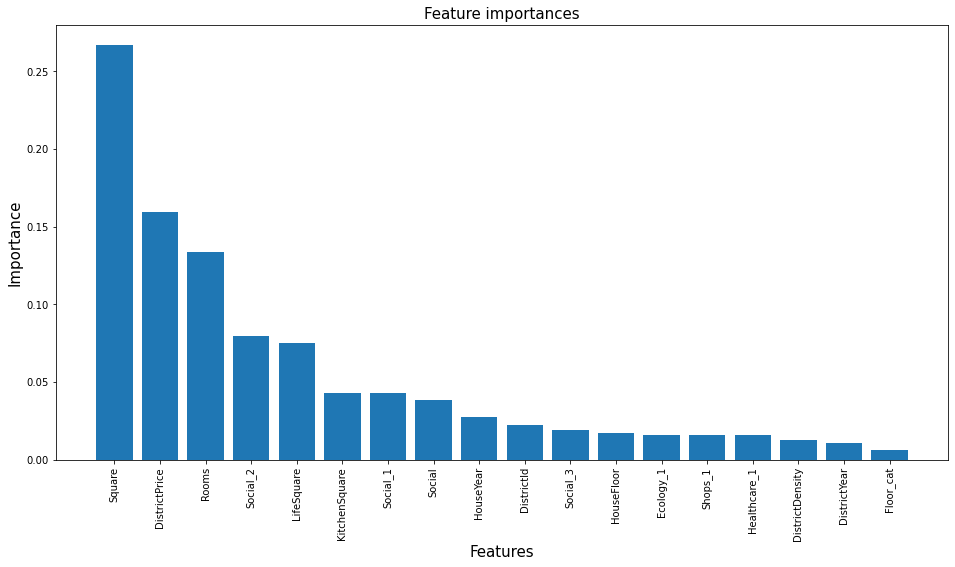

In [32]:
plt.figure(figsize = (16, 8))
plt.bar(feature_importances['feature_name'], feature_importances['importance'])
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature importances', fontsize=15)
plt.show()

In [27]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


### Прогнозирование на тестовом датасете

In [28]:
predictions = gb_model.predict(test_df)
predictions

array([165435.50896375, 116588.76026585, 134761.20282438, ...,
       154089.10383183, 188438.09921404, 283955.07280136])

In [29]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,165435.508964
1,5925,116588.760266
2,960,134761.202824
3,3848,85856.757007
4,746,179405.382840


In [30]:
submit.shape

(5000, 2)

In [31]:
submit.to_csv('gb_submit.csv', index=False)